In [1]:
import os
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap

In [2]:
parent_dir = 'dashboard/raw'
files = sorted([parent_dir + '/' + f for f in os.listdir(parent_dir)])
print(files[0])

dashboard/raw/sae_activations_0.pt


In [3]:
sparsity = torch.load('dashboard/sae_sparsity.pt')


sparsity = sparsity > 1e-4
print((sparsity > 1e-4).sum())

tensor(11763, device='cuda:0')


In [7]:
stack = None

for f in files[:3]:
    data = torch.load(f).T
    if stack is None:
        stack = data
    else:
        stack = torch.cat((stack, data))

print(stack.shape)

stack = stack[:, sparsity]
print(stack.shape)
stack = stack.cpu()

torch.Size([24576, 65536])
torch.Size([24576, 11763])


In [8]:
stats = torch.load('cruft/compact/big_tensor.pt')
stats = stats[:stack.shape[0]].cpu()

views = stats[:, 0]
print(views.shape)

torch.Size([24576])


In [25]:
rand_idx = torch.randperm(views.shape[0])

rand_views = views[rand_idx]

In [13]:
print(stack[:, 0].mean(), stack[:, 0].std())

tensor(1.1957e-06) tensor(8.4370e-05)


In [11]:
scaled_stack = StandardScaler().fit_transform(stack)

In [14]:
print(scaled_stack[:, 0].mean(), scaled_stack[:, 0].std())

6.938893903907228e-18 0.999999999999961


In [31]:
from scipy.stats import pearsonr
from tqdm import tqdm

corrs = []

for i in tqdm(range(scaled_stack.shape[1])):
    corr, _ = pearsonr(scaled_stack[:, i], views)
    # check if corr is nan

    if not np.isnan(corr):
        corrs.append(corr)
    else:
        corrs.append(0)

  0%|          | 0/11763 [00:00<?, ?it/s]/tmp/ipykernel_146805/3559568432.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(scaled_stack[:, i], views)
100%|██████████| 11763/11763 [00:13<00:00, 879.05it/s]


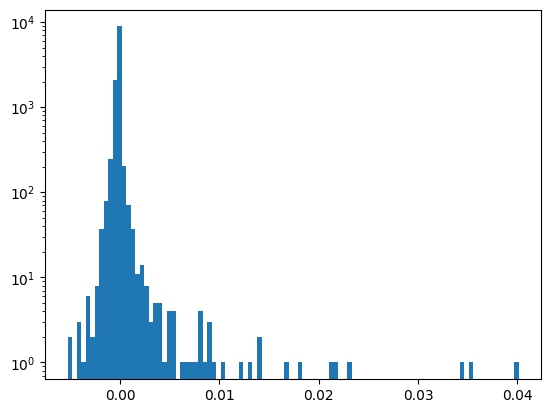

In [23]:
plt.hist(corrs, bins=100)
plt.yscale('log')

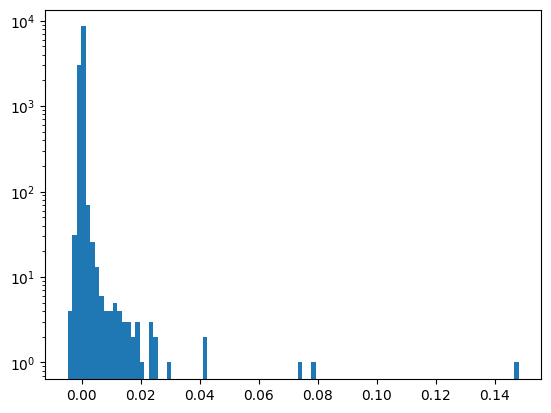

In [29]:
plt.hist(corrs, bins=100)
plt.yscale('log')

In [32]:
corrs = np.array(corrs)

vals, idx = torch.topk(torch.tensor(corrs), 10)

print(vals)
print(idx)

tensor([0.1481, 0.0779, 0.0744, 0.0420, 0.0411, 0.0290, 0.0255, 0.0246, 0.0242,
        0.0235], dtype=torch.float64)
tensor([ 1529,  9160,  3408, 10862,  8499, 10338,  4187,  1329,  5924,  9555])


In [11]:
reducer = umap.UMAP()

In [12]:
embedding = reducer.fit_transform(stack.cpu())
print(embedding.shape)

(24576, 2)


torch.Size([24030])


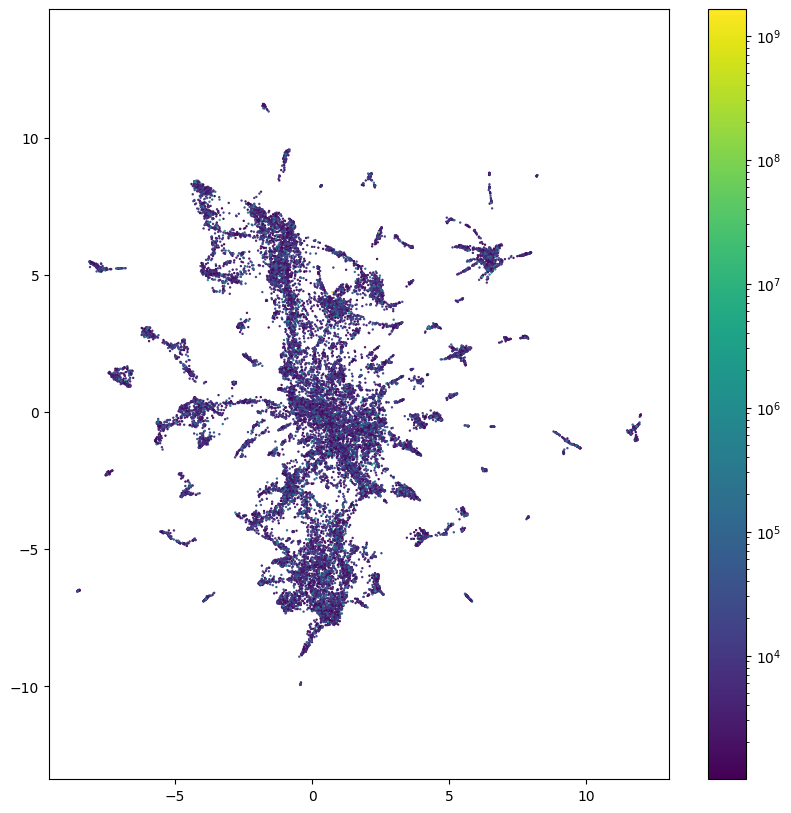

In [15]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 10))

plt.scatter(
    embedding[:24030, 0],
    embedding[:24030, 1],
    c=views,  # Use the likes tensor to color the points
    cmap='viridis',
    norm=LogNorm(),
    s=0.5,
)
plt.colorbar()
plt.gca().set_aspect('equal', 'datalim')

In [3]:
import h5py
from torch.utils.data import Dataset
import os
import torch

from vit_sae_analysis.dashboard_fns import get_feature_data
from sae_training.utils import ViTSparseAutoencoderSessionloader
from loader import ThumbnailDataset
from tqdm import tqdm

import matplotlib.pyplot as plt

In [4]:
q = torch.empty(65000, 500_000, device='cpu')

RuntimeError: [enforce fail at alloc_cpu.cpp:117] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 130000000000 bytes. Error code 12 (Cannot allocate memory)

In [43]:
max_img_indices = torch.load('/home/ubuntu/sae_vit/dashboard/max_activating_image_indices.pt')
mean_acts = torch.load('/home/ubuntu/sae_vit/dashboard/sae_mean_acts.pt')


In [10]:
max_img_indices.shape

torch.Size([65536, 20])

In [47]:
parent_dir = 'cruft/cruft/video/'
files = [parent_dir + f for f in os.listdir(parent_dir) if f.endswith('.h5')]

dataset = ThumbnailDataset(files, keys=['likeCount', 'viewCount', 'commentCount'], device='cpu')
max_file = 524_288
# max_file = 100_000

In [48]:
bs = 5000
like_counts = torch.empty(max_file, dtype=torch.float32, device='cpu')
view_counts = torch.empty(max_file, dtype=torch.float32, device='cpu')
comment_counts = torch.empty(max_file, dtype=torch.float32, device='cpu')
for i in tqdm(range(0, max_file, bs)):
    data = dataset[i:i+bs]

    like_counts[i:i+bs] = data['likeCount']
    view_counts[i:i+bs] = data['viewCount']
    comment_counts[i:i+bs] = data['commentCount']

    

 99%|█████████▉| 104/105 [40:11<00:23, 23.18s/it]


RuntimeError: The expanded size of the tensor (4288) must match the existing size (5000) at non-singleton dimension 0.  Target sizes: [4288].  Tensor sizes: [5000]

In [59]:
data = dataset[i:max_file]

like_counts[i:max_file] = data['likeCount']
view_counts[i:max_file] = data['viewCount']
comment_counts[i:max_file] = data['commentCount']


In [66]:
view_counts = view_counts.to('cuda')
like_counts = like_counts.to('cuda')
comment_counts = comment_counts.to('cuda')

In [70]:
max_img_indices = max_img_indices.to(torch.int64)

In [71]:
max_img_likes = like_counts[max_img_indices]
max_img_img_views = view_counts[max_img_indices]
max_img_comment_counts = comment_counts[max_img_indices]

miv_mean = max_img_likes.mean(dim=1)

(array([5.6662e+04, 4.1990e+03, 1.8890e+03, 1.0620e+03, 6.0900e+02,
        3.6700e+02, 1.6000e+02, 9.5000e+01, 8.5000e+01, 3.9000e+01,
        3.2000e+01, 2.6000e+01, 2.2000e+01, 2.5000e+01, 1.1000e+01,
        1.2000e+01, 8.0000e+00, 5.0000e+00, 1.2000e+01, 5.8000e+01,
        7.0000e+00, 5.0000e+00, 8.0000e+00, 3.1000e+01, 1.1000e+01,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 1.8000e+01, 1.0000e+01,
        7.0000e+00, 1.1000e+01, 6.0000e+00, 1.0000e+01, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        5.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.00

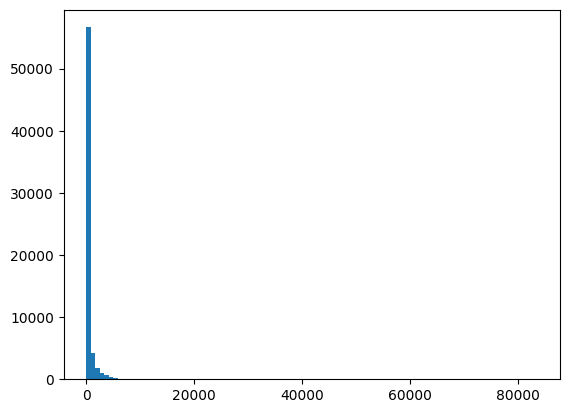

In [73]:
plt.hist(miv_mean.cpu().numpy(), bins=100)

In [79]:
values, indices = torch.topk(miv_mean[:1000], 10)

In [82]:
values

tensor([24045.8008, 19493.9512, 16136.6504, 15969.3506, 15920.5000, 15889.3506,
        14544.2998, 10813.7500,  8263.3506,  6846.1001], device='cuda:0')

tensor([809, 700, 719, 837, 655, 178, 188, 571, 398, 238], device='cuda:0')

In [1]:
import h5py
from torch.utils.data import Dataset
import os
import torch

from vit_sae_analysis.dashboard_fns import get_feature_data
from sae_training.utils import ViTSparseAutoencoderSessionloader

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
class VideoDataDataset(Dataset):
    def __init__(self, file_paths, device, keys=None):
        self.file_paths = file_paths  # List of HDF5 file paths
        self.index_map = []
        self.start_end = {}
        for file_idx, file_path in enumerate(self.file_paths):
            initial_idx = len(self.index_map)
            with h5py.File(file_path, 'r') as hf:
                keys = list(hf.keys())
                # Assuming all datasets have the same length for simplicity
                num_samples = len(hf[keys[0]])
                for i in range(num_samples):
                    self.index_map.append((file_idx, i))

            self.start_end[file_idx] = (initial_idx, len(self.index_map))
                
        self.device = device
        self.keys = keys
        
    def __len__(self):
        return len(self.index_map)

    def _get_item(self, idx, keys):
        return self._get_file_slice(idx, idx + 1, keys)

    def _get_file_slice(self, absolute_start, absolute_end, wanted_keys=None):
        file_idx, _ = self.index_map[absolute_start]
        file_start, _ = self.start_end[file_idx]


        relative_start = absolute_start - file_start
        relative_end = absolute_end - file_start
        file_path = self.file_paths[file_idx]

        with h5py.File(file_path, 'r') as hf:
            keys = list(hf.keys())
            if wanted_keys is not None:
                keys = [key for key in keys if key in wanted_keys]
            data = {
                'thumbnailStandard': torch.tensor(hf['thumbnailStandard'][relative_start:relative_end], device=self.device),
                'likeCount': torch.tensor(hf['likeCount'][relative_start:relative_end], device=self.device) if 'likeCount' in keys else None,
                'viewCount': torch.tensor(hf['viewCount'][relative_start:relative_end], device=self.device) if 'viewCount' in keys else None,
                'commentCount': torch.tensor(hf['commentCount'][relative_start:relative_end], device=self.device) if 'commentCount' in keys else None,
                'title': list(hf['title'][relative_start:relative_end]) if 'title' in keys else None
            }
        return data

    def _get_whole_file(self, file_idx, keys):
        start, end = self.start_end[file_idx]
        return self._get_file_slice(start, end, keys)

    def _return_multi_file_slice(self, start, end, keys):
        all_indices = self.index_map[start:end]

        whole_files = list()

        last_file_idx = None
        first_file_idx = None
        for file_idx, _ in all_indices:
            if file_idx not in whole_files:
                whole_files.append(file_idx)
            last_file_idx = file_idx
            
            if first_file_idx is None:
                first_file_idx = file_idx

        if first_file_idx == last_file_idx:
            return self._get_file_slice(start, end, keys)

        whole_files = [idx for idx in whole_files if idx != first_file_idx and idx != last_file_idx]

        sample_lists = []
    
        _, end_of_first_file = self.start_end[first_file_idx]
        first_file_samples = self._get_file_slice(start, end_of_first_file, keys)
        sample_lists.append(first_file_samples)

        for file_idx in whole_files:
            sample_lists.append(self._get_whole_file(file_idx, keys))

        start_of_last_file, _ = self.start_end[last_file_idx]
        last_file_samples = self._get_file_slice(start_of_last_file, end, keys)
        sample_lists.append(last_file_samples)
        
        data = None
        for samples in sample_lists:
            if data is None:
                data = samples
            else:
                for key in data.keys():
                    if key == 'title':
                        data[key] = data[key] + samples[key]
                    else:    
                        data[key] = torch.cat((data[key], samples[key]), 0)

        return data


    def __getitem__(self, idx):
        if isinstance(idx, slice):
            start = idx.start if idx.start is not None else 0
            stop = idx.stop if idx.stop is not None else len(self.index_map)

            if idx.step is not None:
                raise ValueError("Slicing with step is not supported", idx)

            return self._return_multi_file_slice(start, stop, self.keys)

        return self._get_item(idx, self.keys)

In [ ]:
parent_dir = 'cruft/cruft/video/'
files = [parent_dir + f for f in os.listdir(parent_dir) if f.endswith('.h5')]

dataset = VideoDataDataset(files, keys=['thumbnailStandard'], device='cpu')

In [4]:
filename = 'checkpoints/4rfb746w/final_sparse_autoencoder_openai/clip-vit-large-patch14_-2_resid_65536.pt'
data = torch.load(filename)

In [5]:
cfg = data['cfg']

In [6]:
model, sparse_autoencoder, activations_loader = ViTSparseAutoencoderSessionloader.load_session_from_pretrained(filename)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/39 [00:00<?, ?it/s]

Starting to create the data loader!!!


Getting batches for SAE: 100%|██████████| 15/15 [02:06<00:00,  8.42s/it]


Data loader created!!!


In [7]:
model

In [8]:
image_batch = dataset[0:5]['thumbnailStandard']

In [17]:
model.processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  },
  "use_square_size": false
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|st

In [10]:
inputs = model.processor(images=image_batch, text = "", return_tensors="pt", padding = True).to(model.model.device)

In [16]:
inputs.pixel_values.shape

torch.Size([5, 3, 224, 224])

In [15]:
inputs.input_ids

tensor([[49406, 49407]], device='cuda:0')

In [13]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [5]:
get_feature_data(
    sparse_autoencoder,
    model,
    load_pretrained=True,
    threshold=0.04,
    number_of_images=524_288,
    number_of_max_activating_images=20,
    dataset=dataset,
)

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 129.52it/s]
